# Adversarial Targeted Dataset Simulation

In [1]:
# Paths
LAINET_PATH = '/local-scratch/mrivas/dmasmont/misc/lnpfoo/lainet_trained.pth'
NEURALADM_PATH = '/local-scratch/mrivas/dmasmont/misc/lnpfoo/adv.pt'
device = 'cuda:4'
founders_vcf_file_path = '/local-scratch/mrivas/dmasmont/L3N/datasets/chr20_8anc_100/founders_train.vcf'
founders_map_file_path = '/local-scratch/mrivas/dmasmont/L3N/datasets/chr20_8anc_100/founders_train.map'
output_folder_prefix = '/local-scratch/mrivas/dmasmont/misc/lnpfoo/'

### Importing libraries, datasets, and networks

In [2]:
# Importing libraries
print('Start importing required libraries...')
import os, sys, time, allel, yaml, math, gzip, torch
sys.path.append('../LAI-Net/')
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
from scipy.interpolate import interp1d
from matplotlib import cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import pickle as pkl
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.decomposition import PCA
import sklearn
from sklearn import neighbors, datasets

from lainet.utils.reader import load_founders_from_vcf_and_map

from helpers.method_inference import forward_haploid, forward_nadm, extend_if_lai, compute_pca, unique_to_percentage
from helpers.binarize import binarize
from helpers.adversarial_perturbation import cw_loss, subsample_adversarial_mask, eval_net_and_subsample, generate_adversarial_mask, run_robustness_analysis
from helpers.adversarial_synthesis import generate_adversarial_population

print('Done importing, using pytorch version {}...'.format(torch.__version__))

Start importing required libraries...
Done importing, using pytorch version 1.12.1+cu102...


In [3]:
# Loading dataset
snps_all, labels_all, _, _, ancestry_names, _ = load_founders_from_vcf_and_map(founders_vcf_file_path, founders_map_file_path, make_haploid=True, random_split=False, verbose=True)

subset = 2
snps, labels = snps_all[0::subset,:], labels_all[0::subset]
snps_test, labels_test = snps_all[1::subset,:], labels_all[1::subset]
print(snps.shape, labels.shape, snps_test.shape, labels_test.shape)

Loading vcf and .map files...
Done loading vcf and .map files...
A total of 3200 diploid individuals where found in the vcf and .map
A total of 8 ancestries where found: ['AFR' 'AHG' 'AMR' 'EAS' 'EUR' 'OCE' 'SAS' 'WAS']
(2880, 516800) (2880,) (2880, 516800) (2880,)


In [4]:
# Loading LAI-Net
import lainet
print(f'Loading LAI-Net from {LAINET_PATH} ...')
LN = torch.load(LAINET_PATH, map_location=device)
LN.device = device
LN = LN.to(device)
LN = LN.eval()
print('Done loading LAI-Net')

Loading LAI-Net from /local-scratch/mrivas/dmasmont/misc/lnpfoo/lainet_trained.pth ...
Done loading LAI-Net


In [5]:
# Loading Neural ADMIXTURE
from neural_admixture.model.neural_admixture import NeuralAdmixture
print(f'Loading Neural ADMIXTURE from {NEURALADM_PATH} ...')
NADM= NeuralAdmixture([8], num_features=516800)
NADM.load_state_dict(torch.load(NEURALADM_PATH, map_location=device), strict=True)
NADM.device = device
NADM = NADM.to(device)
NADM = NADM.eval()
print('Done loading Neural ADMIXTURE')

Loading Neural ADMIXTURE from /local-scratch/mrivas/dmasmont/misc/lnpfoo/adv.pt ...
Done loading Neural ADMIXTURE


In [6]:
# Setup PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(snps)
W = torch.tensor(pca.components_)
b =  torch.tensor(pca.mean_)

pcat, _, _, _ = compute_pca(torch.tensor(snps), W, b)
pcat = pcat.numpy()

In [7]:
# Setup Fast K-NN
knn_dim = 1024
knn_W = torch.randn((snps.shape[1], knn_dim)) * (1/(2*torch.sqrt(torch.tensor(knn_dim))))
KNN = neighbors.KNeighborsClassifier(n_neighbors=1)
train_template = np.matmul(snps, knn_W.cpu().numpy())
KNN.fit(train_template, labels)

KNeighborsClassifier(n_neighbors=1)

### Generate and store fake dataset

In [8]:
# Get real, random, and fake datasets
N_SAMPLES = 50

#[0'AFR' 1'AHG' 2'AMR' 3'EAS' 4'EUR' 5'OCE' 6'SAS' 7'WAS']
target_label_pca = 4
target_label_lainet = 2
target_label_nadm = 5
target_knn_label = 1
num_iters = 800
fake_sequence = generate_adversarial_population(N_SAMPLES, snps.shape[1], snps, labels, (W,b), target_label_pca, LN, target_label_lainet, knn_W, target_knn_label, NADM, target_label_nadm, device, num_iters = num_iters)

random_sequence = torch.bernoulli(torch.mean(torch.tensor(snps).float(), dim=0, keepdims=True).repeat(N_SAMPLES,1)).float().to(device)
real_sequence = torch.tensor(snps_test[labels_test==4,:]).float()[0:N_SAMPLES,:].to(device)

0 422.16282166997433 tensor(5, device='cuda:4') tensor(0, device='cuda:4') 302.87279166738034 2.062979221343994 43.42768859863281 30.371673583984375
1 415.6721182443901 tensor(5, device='cuda:4') tensor(0, device='cuda:4') 297.23010569594345 2.050555944442749 43.24954605102539 29.892364501953125
2 409.12463918572126 tensor(5, device='cuda:4') tensor(0, device='cuda:4') 291.53596845513044 2.0385913848876953 43.0701789855957 29.40972137451172
3 402.74690254400923 tensor(5, device='cuda:4') tensor(0, device='cuda:4') 285.9865129775877 2.0260393619537354 42.894527435302734 28.945295333862305
4 396.4503164327722 tensor(5, device='cuda:4') tensor(0, device='cuda:4') 280.49679923420956 2.0140297412872314 42.724708557128906 28.490070343017578
5 390.22761353919293 tensor(5, device='cuda:4') tensor(0, device='cuda:4') 275.0923665470817 2.001671552658081 42.55233383178711 28.028907775878906
6 384.002775236675 tensor(5, device='cuda:4') tensor(0, device='cuda:4') 269.700035497257 1.989770531654358

In [18]:
# Store datasets
dict_to_save = {
'name' : 'Manipulated',
'real_seqs' : snps,
'fake_seqs' : fake_sequence.cpu().numpy()
}

with open(output_folder_prefix+f'dataset_manipulated.pkl', 'wb') as handle:
    pkl.dump(dict_to_save, handle, protocol=pkl.HIGHEST_PROTOCOL)

### Perform inference with PCA, KNN, LAI-Net, and Neural ADMIXTURE

In [10]:
###############################################################
## Perform Inference ##########################################
###############################################################

## Real sequence ##############################################
## PCA
pcs_real, _, _, _ = compute_pca(real_sequence.cpu(), W, b)

## KNN
pred_real_knn = KNN.predict(np.matmul(real_sequence.cpu().numpy(), knn_W.cpu().numpy()))
unique, count = np.unique(pred_real_knn, return_counts=True)
real_eur_knn = unique_to_percentage(unique, count, 8)

## LAI-Net
_, pred_real = forward_haploid(LN.eval(), real_sequence)
unique, count = torch.unique(pred_real, return_counts=True)
real_eur_lainet = unique_to_percentage(unique.cpu().numpy(), count.cpu().numpy(), 8)

## Neural ADMIXTURE
_, pred_nadm_real = forward_nadm(NADM, real_sequence)
unique, count = torch.unique(pred_nadm_real, return_counts=True)
real_eur_nadm = unique_to_percentage(unique.cpu().numpy(), count.cpu().numpy(), 8)


## Random sequence ###########################################
## PCA
pcs_random, _, _, _ = compute_pca(random_sequence.cpu(), W, b)

## KNN
pred_random_knn = KNN.predict(np.matmul(random_sequence.cpu().numpy(), knn_W.cpu().numpy()))
unique, count = np.unique(pred_random_knn, return_counts=True)
random_knn = unique_to_percentage(unique, count, 8)

## LAI-Net
_, pred_random = forward_haploid(LN.eval(), random_sequence)
unique, count = torch.unique(pred_random, return_counts=True)
random_lainet = unique_to_percentage(unique.cpu().numpy(), count.cpu().numpy(), 8)

## Neural ADMIXTURE
_, pred_nadm_random = forward_nadm(NADM, random_sequence)
unique, count = torch.unique(pred_nadm_random, return_counts=True)
random_nadm = unique_to_percentage(unique.cpu().numpy(), count.cpu().numpy(), 8)


## Adversarial sequence ###########################################
## PCA
pcs_fake, _, _, _ = compute_pca(fake_sequence.cpu(), W, b)

## KNN
pred_random_knn = KNN.predict(np.matmul(fake_sequence.cpu().numpy(), knn_W.cpu().numpy()))
unique, count = np.unique(pred_random_knn, return_counts=True)
fake_knn = unique_to_percentage(unique, count, 8)

## LAI-Net
_, pred_random = forward_haploid(LN.eval(), fake_sequence)
unique, count = torch.unique(pred_random, return_counts=True)
fake_lainet = unique_to_percentage(unique.cpu().numpy(), count.cpu().numpy(), 8)

## Neural ADMIXTURE
_, pred_nadm_random = forward_nadm(NADM, fake_sequence)
unique, count = torch.unique(pred_nadm_random, return_counts=True)
fake_nadm = unique_to_percentage(unique.cpu().numpy(), count.cpu().numpy(), 8)

### Make Final Plot

<ipython-input-16-b99ceb9ae421>:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  axd[k].set_xticklabels(ancestry_names, rotation = 45)


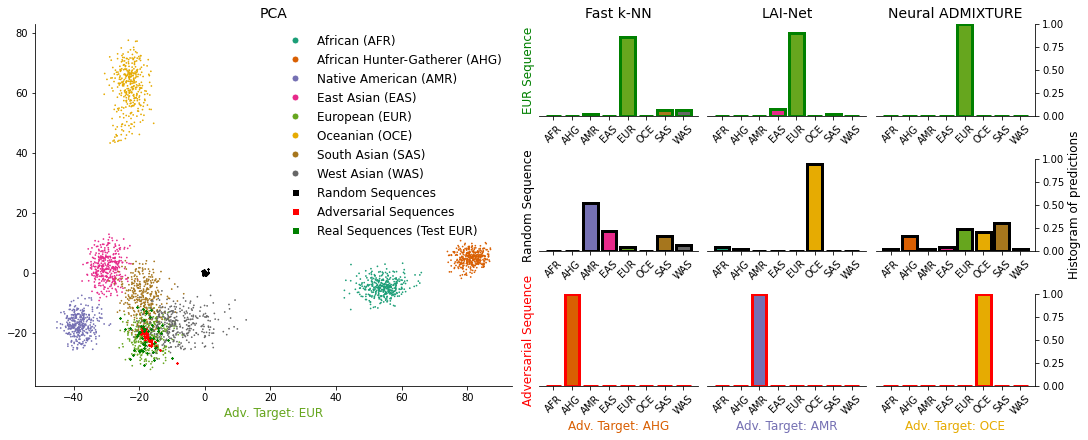

In [16]:
from matplotlib import cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


cmap = cm.get_cmap('Dark2', 8) #'magma' #'plasma' #'cividis'
color_list = cmap([j for j in range(8)])

axd = plt.figure(constrained_layout=True, figsize=(15, 6)).subplot_mosaic(
    """
    AAABCD
    AAAEFG
    AAAHIJ
    """
)

axd['A'].scatter(pcat[:,0], pcat[:,1], c=labels, marker='.', s=2.0, cmap=cmap)
axd['A'].scatter(pcs_fake.numpy()[:,0], pcs_fake.numpy()[:,1], c='red', marker='x', s=2.5, cmap=cmap)
axd['A'].scatter(pcs_random.numpy()[:,0], pcs_random.numpy()[:,1], c='black', marker='x', s=2.5, cmap=cmap)
axd['A'].scatter(pcs_real.numpy()[:,0], pcs_real.numpy()[:,1], c='green', marker='x', s=2.5, cmap=cmap)


real_edge_color = 'g'
random_edge_color = 'black'
adversarial_edge_color = 'r'


linewidth=3

axd['B'].bar(ancestry_names, real_eur_knn, edgecolor=real_edge_color, color=color_list, linewidth=linewidth)
axd['C'].bar(ancestry_names, real_eur_lainet, edgecolor=real_edge_color, color=color_list, linewidth=linewidth)
axd['D'].bar(ancestry_names, real_eur_nadm, edgecolor=real_edge_color, color=color_list, linewidth=linewidth)

axd['E'].bar(ancestry_names, random_knn, edgecolor=random_edge_color, color=color_list, linewidth=linewidth)
axd['F'].bar(ancestry_names, random_lainet, edgecolor=random_edge_color, color=color_list, linewidth=linewidth)
axd['G'].bar(ancestry_names, random_nadm, edgecolor=random_edge_color, color=color_list, linewidth=linewidth)


axd['H'].bar(ancestry_names, fake_knn, edgecolor=adversarial_edge_color, color=color_list, linewidth=linewidth)
axd['I'].bar(ancestry_names, fake_lainet, edgecolor=adversarial_edge_color, color=color_list, linewidth=linewidth)
axd['J'].bar(ancestry_names, fake_nadm, edgecolor=adversarial_edge_color, color=color_list, linewidth=linewidth)



"""
AAABCD
AAAEFG
AAAHIJ
"""

fsize_label_axis = 12

axd['A'].set_xlabel(f'Adv. Target: {ancestry_names[target_label_pca]}', fontsize=fsize_label_axis)
axd['A'].xaxis.label.set_color(color_list[target_label_pca])
axd['H'].set_xlabel(f'Adv. Target: {ancestry_names[target_knn_label]}', fontsize=fsize_label_axis)
axd['H'].xaxis.label.set_color(color_list[target_knn_label])
axd['I'].set_xlabel(f'Adv. Target: {ancestry_names[target_label_lainet]}', fontsize=fsize_label_axis)
axd['I'].xaxis.label.set_color(color_list[target_label_lainet])
axd['J'].set_xlabel(f'Adv. Target: {ancestry_names[target_label_nadm]}', fontsize=fsize_label_axis)
axd['J'].xaxis.label.set_color(color_list[target_label_nadm])
    

    
axd['G'].set_ylabel('Histogram of predictions', fontsize=fsize_label_axis)
axd['G'].yaxis.set_label_position('right') 
#axd['G'].yaxis.label_right()
    
for k in ['B', 'E', 'H', 'C', 'F', 'I']:
    axd[k].spines['right'].set_visible(False)
    axd[k].spines['top'].set_visible(False)
    axd[k].spines['left'].set_visible(False)
    axd[k].set_yticks([])
    
for k in ['D',  'G', 'J']:
    #axd[k].spines['right'].set_visible(False)
    axd[k].spines['top'].set_visible(False)
    axd[k].spines['left'].set_visible(False)
    #axd[k].set_yticks([])
    
for k in ['A']:
    axd[k].spines['right'].set_visible(False)
    axd[k].spines['top'].set_visible(False)
    
    
for k in ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']:
    axd[k].yaxis.tick_right()


axd['B'].set_ylabel('EUR Sequence', fontsize=fsize_label_axis)
axd['B'].yaxis.label.set_color('green')
axd['E'].set_ylabel('Random Sequence', fontsize=fsize_label_axis)
axd['H'].set_ylabel('Adversarial Sequence', fontsize=fsize_label_axis)
axd['H'].yaxis.label.set_color('red')



for k in ['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']:
    axd[k].set_ylim([0.0,1.0])
    axd[k].set_xticklabels(ancestry_names, rotation = 45)
    
for k, t in zip(['A', 'B', 'C', 'D'], ['PCA', 'Fast k-NN', 'LAI-Net', 'Neural ADMIXTURE']):
    axd[k].set_title(t, fontsize=14)

    


    
legend_elements = [Line2D([0], [0], color='b', lw=4, label='Line'),
                   Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='g', markersize=15),
                   Patch(facecolor='orange', edgecolor='r',
                         label='Color Patch')]


#[0'AFR' 1'AHG' 2'AMR' 3'EAS' 4'EUR' 5'OCE' 6'SAS' 7'WAS']
markersize = 7
legend_elements = [
                    Line2D([0], [0], marker='o', color='w', label='African (AFR)',markerfacecolor=color_list[0], markersize=markersize),
                    Line2D([0], [0], marker='o', color='w', label='African Hunter-Gatherer (AHG)',markerfacecolor=color_list[1], markersize=markersize),
                    Line2D([0], [0], marker='o', color='w', label='Native American (AMR)',markerfacecolor=color_list[2], markersize=markersize),
                    Line2D([0], [0], marker='o', color='w', label='East Asian (EAS)',markerfacecolor=color_list[3], markersize=markersize),
                    Line2D([0], [0], marker='o', color='w', label='European (EUR)',markerfacecolor=color_list[4], markersize=markersize),
                    Line2D([0], [0], marker='o', color='w', label='Oceanian (OCE)',markerfacecolor=color_list[5], markersize=markersize),
                    Line2D([0], [0], marker='o', color='w', label='South Asian (SAS)',markerfacecolor=color_list[6], markersize=markersize),
                    Line2D([0], [0], marker='o', color='w', label='West Asian (WAS)',markerfacecolor=color_list[7], markersize=markersize),
                    Line2D([0], [0], marker='s', color='w', label='Random Sequences',markerfacecolor='black', markersize=markersize),
                    Line2D([0], [0], marker='s', color='w', label='Adversarial Sequences',markerfacecolor='r', markersize=markersize),
                    Line2D([0], [0], marker='s', color='w', label='Real Sequences (Test EUR)',markerfacecolor='green', markersize=markersize),
]


axd['A'].legend(handles=legend_elements, loc='upper right', fontsize=12, frameon=False)


plt.savefig('figs/fake_dataset.png')
plt.show()